In [18]:
import pandas as pd
import numpy as np

from wordcloud import WordCloud
import seaborn as sea
import matplotlib.pyplot as plt

from sklearn.metrics import r2_score, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import roc_curve

In [19]:
dataset = pd.read_csv ('spam.csv', encoding='latin-1')
df = pd.DataFrame (dataset)
df

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN
...,...,...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,NaN,NaN,NaN
5568,ham,Will Ì_ b going to esplanade fr home?,NaN,NaN,NaN
5569,ham,"Pity, * was in mood for that. So...any other s...",NaN,NaN,NaN
5570,ham,The guy did some bitching but I acted like i'd...,NaN,NaN,NaN


In [20]:
df.drop (['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis=1, inplace=True)
df['v1'], df['v2'] = df['v2'], df['v1']
df.rename (columns={'v1': 'email', 'v2': 'classification'}, inplace=True)
replace_classifications = {'ham': 0, 'spam': 1}
df['classification'] = df['classification'].replace (replace_classifications)

In [21]:
df.isna ().sum ()

email             0
classification    0
dtype: int64

In [22]:
from pandas import get_dummies

def one_hot_encoding (df):
    new_cols = pd.DataFrame ()
    for column in df.columns:
        if df[column].dtype == 'int':
            dummy = get_dummies (df[column])
            new_cols = pd.concat ([new_cols, dummy], axis=1)

    return pd.concat ([df, new_cols], axis=1)

df = one_hot_encoding (df)
df

,email,classification,0,1
0,"Go until jurong point, crazy.. Available only ...",0,1,0
1,Ok lar... Joking wif u oni...,0,1,0
2,Free entry in 2 a wkly comp to win FA Cup fina...,1,0,1
3,U dun say so early hor... U c already then say...,0,1,0
4,"Nah I don't think he goes to usf, he lives aro...",0,1,0
...,...,...,...,...
5567,This is the 2nd time we have tried 2 contact u...,1,0,1
5568,Will Ì_ b going to esplanade fr home?,0,1,0
5569,"Pity, * was in mood for that. So...any other s...",0,1,0
5570,The guy did some bitching but I acted like i'd...,0,1,0


In [23]:
tfidf = TfidfVectorizer ()

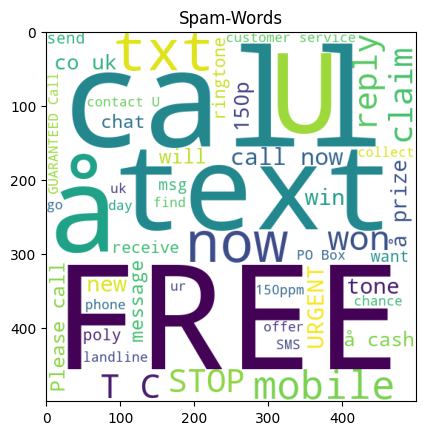

In [24]:
wcloud = WordCloud (width=500, height=500, min_font_size=15, background_color='white')
spam_words = wcloud.generate (df[df['classification'] == 1]['email'].str.cat (sep=' '))
plt.title ('Spam-Words')
plt.imshow (spam_words)

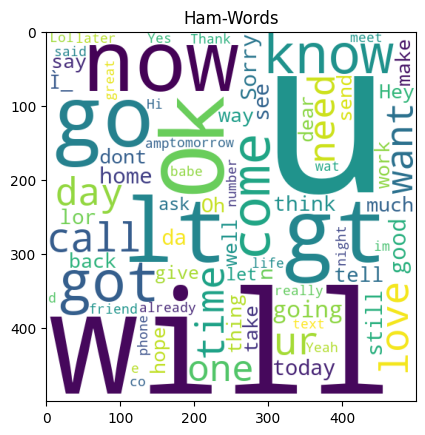

In [25]:
ham_words = wcloud.generate (df[df['classification'] == 0]['email'].str.cat (sep=' '))
plt.title ('Ham-Words')
plt.imshow (ham_words)

<Axes: ylabel='classification'>

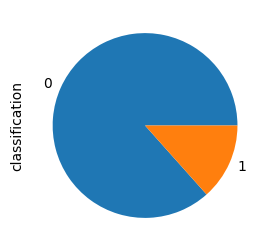

In [37]:
X = tfidf.fit_transform (df.email).toarray ()
yhat = df.classification
yhat.value_counts ().plot (kind='pie', figsize=(4, 3))

In [38]:
X_train, X_test, y_train, y_test = train_test_split (X, yhat, test_size=0.3, random_state=1)

In [54]:
def pipeliner (models):
    model_pipelines = list ()
    for i in range (len (models)):
        sname, mname = f'scaler{i}', str.lower (models[i].__class__.__name__)
        pipe = Pipeline ([
            (mname, models[i])
        ])
        model_pipelines.append (pipe)
    
    for pipe in model_pipelines:
        pipe.fit (X_train, y_train)

    result_mse = dict ()
    for i, model in enumerate (model_pipelines):
        cv_score = cross_val_score (model, X_train, y_train, scoring="neg_mean_squared_error")
        result_mse[cv_score.mean ()] = model
    
    for K, V in result_mse.items ():
        print (K, V)
    
    return result_mse[max (result_mse.keys ())], model_pipelines

model, pipelines = pipeliner ([BernoulliNB (), GaussianNB (), LogisticRegression (), MultinomialNB ()])

model.fit (X_train, y_train)

-0.02358974358974359 Pipeline(steps=[('bernoullinb', BernoulliNB())])
-0.09 Pipeline(steps=[('gaussiannb', GaussianNB())])
-0.046153846153846156 Pipeline(steps=[('logisticregression', LogisticRegression())])
-0.0541025641025641 Pipeline(steps=[('multinomialnb', MultinomialNB())])


Pipeline(steps=[('bernoullinb', BernoulliNB())])

<Axes: >

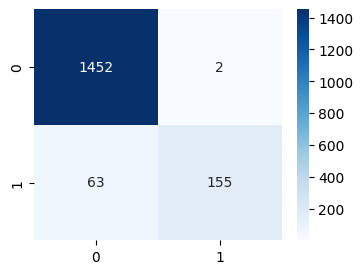

In [49]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict (X_test)
conf_matrix = confusion_matrix (y_test, y_pred)
plt.figure (figsize=(4, 3))
sea.heatmap (conf_matrix, annot=True, fmt='', cmap='Blues')

In [43]:
from sklearn.metrics import classification_report
report = classification_report (y_test, y_pred)
print (report)

              precision    recall  f1-score   support

           0       0.96      1.00      0.98      1454
           1       0.99      0.71      0.83       218

    accuracy                           0.96      1672
   macro avg       0.97      0.85      0.90      1672
weighted avg       0.96      0.96      0.96      1672



0.5430829707174539
0.9611244019138756


array([1.9459677 , 0.9459677 , 0.90273147, 0.90145857, 0.86120672,
       0.85773802, 0.82271241, 0.82121272, 0.77719628, 0.77671965,
       0.70991979, 0.70899815, 0.69062014, 0.68878787, 0.63749867,
       0.63663502, 0.44824838, 0.41352502, 0.4132529 , 0.40871087,
       0.38364111, 0.38318673, 0.38114562, 0.35239693, 0.35151518,
       0.34986428, 0.34899422, 0.34557819, 0.33239723, 0.33118133,
       0.33027148, 0.3232249 , 0.31856999, 0.31139676, 0.28179596,
       0.27665317, 0.27461803, 0.25895467, 0.25436467, 0.25422725,
       0.23786396, 0.22829484, 0.21609213, 0.21464031, 0.20561079,
       0.19285942, 0.19036346, 0.19027065, 0.18948236, 0.17454717,
       0.17428949, 0.17261294, 0.14628618, 0.14612959, 0.12379526,
       0.12365331, 0.12186973, 0.12153695, 0.11665892, 0.11663714,
       0.11397835, 0.11391414, 0.11081044, 0.11071658, 0.10687587,
       0.10641994, 0.10575472, 0.10477685, 0.10398821, 0.10391843,
       0.09467445, 0.09390607, 0.08684105, 0.08670767, 0.08309

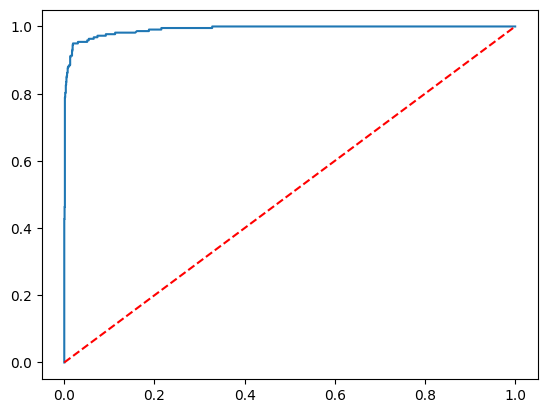

In [53]:
y_pred = model.predict (X_test)
print (r2_score (y_pred, y_test))
print (model.score (X_test, y_test))

y_pred_prob = model.predict_proba (X_test)[:, 1]
f, t, thresholds = roc_curve (y_test, y_pred_prob)
plt.plot(f, t, label='ROC Curve')
plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')
thresholds

In [58]:
query = tfidf.transform (['Students are building leadership skills and tackling social, economic, and political issues through Prezi — impressive, right? Nonprofit Summa San shares how Prezi can help you engage your students, too.Learn how student leaders everywhere are using Prezi to bring awareness to and solve some of the world’s most pressing problems.We’ll have Q&A time for those who tune in live, but even if you can’t make it, please register so we can send you the recording'])

In [59]:
classify = {
    0: 'not spam',
    1: 'spam'
}

In [60]:
classify[model.predict (query)[0]]

'not spam'

In [51]:
import pickle
pickle.dump (model, open ('spamham.pkl', 'wb'))